<a id="top"></a>

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

***

# Table of Contents

- [1.Introduction](#1)
    + [1.1. The Problem](#1.1)
    + [1.2. The Clean Dataset](#1.2)
 
 
- [2. Data Understanding and Preparation](#2)
    + [2.1. Splitting Dataset into Training and Test Sets](#2.1)
    + [2.2. On the Training Set](#2.2)
        - [2.2.1. Correlations between Continuous Features](#2.2.1)
        - [2.2.2. Continuous Features Interaction with Target Feature](#2.2.2)
        - [2.2.3. Promising Continuous Features](#2.2.3)
        - [2.2.4. Categorical Feature Pairwise Interactions with Target Feature](#2.2.4)
        - [2.2.5. Promising Categorical Features](#2.2.5)
 
 
- [3. Predictive Modeling: Linear Regression](#3)
    + [3.1. Linear Regression Model](#3.1)
    + [3.2. Coefficients of the Model](#3.2)
    + [3.3. Predicted Target Feature Value](#3.3)
    + [3.4. Model Evaluation](#3.4)


- [4. Predictive Modeling: Logistic Regression](#4)
    + [4.1. Logistic Regression Model](#4.1)
    + [4.2. Coefficients of the Model](#4.2)
    + [4.3. Predicted Target Feature Value](#4.3)
    + [4.4. Model Evaluation](#4.4)
  
  
- [5. Predictive Modeling: Random Forest](#5)
    + [5.1. Random Forest Model](#5.1)
    + [5.2. Model Interpretation](#5.2)
    + [5.3. Predicted Target Value](#5.3)
    + [5.4. Model Evaluation](#5.4)
 
 
- [6. Improving the Predictive Models](#6)
    + [6.1. Best Predictive Model](#6.1)
    + [6.2. Problem Summary](#6.2)
    + [6.3. Model Evaluation on New Test Dataset](#6.3)


***

<a id="1"></a>
# 1. Introduction

<a id="1.1"></a>
## 1.1 The Problem

The focus of this project is to build a data analytics solution for death risk prediction.  
This project will build three different prediction models that capture the relationship between the descriptive features and the target feature 'death_yn'.  
The dataset is taken from my homework 1 assignment which cleaned and prepared the data taken from the Centers for Disease Control and Prevention (CDC) in the USA.

<a id="1.2"></a>
## 1.2 The Clean Dataset

In [88]:
# Load in cleaned dataset from Homework 1
df = pd.read_csv("data/covid19-cdc-20204844_1-2_cleaned.csv")

In [70]:
# Print the number of rows and features in the dataset
num_rows = df.shape[0]
features = df.shape[1]
print(f"The dataset has {num_rows} rows with {features} features.")

The dataset has 8509 rows with 10 features.


In [71]:
# Print the first 5 rows
print("The first 5 Rows are:")
df.head(5)

The first 5 Rows are:


,id,cdc_case_earliest_dt,onset_dt,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,0,18/03/2020,18/03/2020,Male,20 - 29 Years,Unknown,No,Unknown,No,Yes
1,1,04/12/2020,NaN,Female,10 - 19 Years,"Multiple/Other, Non-Hispanic",No,Unknown,No,Unknown
2,2,12/01/2021,NaN,Male,0 - 9 Years,Unknown,Unknown,Unknown,No,Unknown
3,3,04/11/2020,04/11/2020,Male,50 - 59 Years,"White, Non-Hispanic",No,Unknown,No,No
4,4,10/04/2020,10/04/2020,Male,50 - 59 Years,Unknown,No,Unknown,No,Unknown


In [72]:
print("The last 5 Rows are:")
df.tail(5)

The last 5 Rows are:


,id,cdc_case_earliest_dt,onset_dt,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
8504,9995,14/12/2020,14/12/2020,Male,30 - 39 Years,Unknown,No,Unknown,No,Unknown
8505,9996,18/08/2020,18/08/2020,Male,50 - 59 Years,"White, Non-Hispanic",Unknown,Unknown,No,No
8506,9997,15/04/2020,15/04/2020,Male,50 - 59 Years,Hispanic/Latino,No,Unknown,No,Yes
8507,9998,17/12/2020,NaN,Male,40 - 49 Years,"White, Non-Hispanic",No,Unknown,No,Unknown
8508,9999,29/06/2020,NaN,Female,30 - 39 Years,"White, Non-Hispanic",No,Unknown,No,Unknown


In [73]:
df.dtypes

id                          int64
cdc_case_earliest_dt       object
onset_dt                   object
sex                        object
age_group                  object
race_ethnicity_combined    object
hosp_yn                    object
icu_yn                     object
death_yn                   object
medcond_yn                 object
dtype: object

In [74]:
# Select columns containing categorical data
categorical_features = df[['sex','age_group','race_ethnicity_combined','hosp_yn','icu_yn','death_yn','medcond_yn']].columns

# Change the column type to category
for column in categorical_features:
    df[column] = df[column].astype('category')

In [75]:
# Select columns containing continuous data (the dates)
continuous_features = df[['cdc_case_earliest_dt','onset_dt']].columns

# Change the column type to datetime
for column in continuous_features:
    df[column] = df[column].astype('datetime64')

In [76]:
df.dtypes

id                                  int64
cdc_case_earliest_dt       datetime64[ns]
onset_dt                   datetime64[ns]
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                         category
medcond_yn                       category
dtype: object

In [77]:
# Print data balance of target feature
df['death_yn'].value_counts()

No     8214
Yes     295
Name: death_yn, dtype: int64

***

<a id="2"></a>
# 2. Data Understanding and Preparation
Exploring relationships between feature pairs and selecting/transforming promising features based on a given training set.

<a id="2.1"></a>
## 2.1 Splitting Dataset into Training and Test Sets

In [89]:
# Transform target feature death_yn into a categorical feature named death class
DeathClass = (df.death_yn == "Yes") * 1.0

# Add DeathClass to dataframe and drop death_yn
df['DeathClass'] = DeathClass
df.drop('death_yn', axis=1, inplace=True)
df

,id,cdc_case_earliest_dt,onset_dt,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,medcond_yn,DeathClass
0,0,18/03/2020,18/03/2020,Male,20 - 29 Years,Unknown,No,Unknown,Yes,0.0
1,1,04/12/2020,NaN,Female,10 - 19 Years,"Multiple/Other, Non-Hispanic",No,Unknown,Unknown,0.0
2,2,12/01/2021,NaN,Male,0 - 9 Years,Unknown,Unknown,Unknown,Unknown,0.0
3,3,04/11/2020,04/11/2020,Male,50 - 59 Years,"White, Non-Hispanic",No,Unknown,No,0.0
4,4,10/04/2020,10/04/2020,Male,50 - 59 Years,Unknown,No,Unknown,Unknown,0.0
...,...,...,...,...,...,...,...,...,...,...
8504,9995,14/12/2020,14/12/2020,Male,30 - 39 Years,Unknown,No,Unknown,Unknown,0.0
8505,9996,18/08/2020,18/08/2020,Male,50 - 59 Years,"White, Non-Hispanic",Unknown,Unknown,No,0.0
8506,9997,15/04/2020,15/04/2020,Male,50 - 59 Years,Hispanic/Latino,No,Unknown,Yes,0.0
8507,9998,17/12/2020,NaN,Male,40 - 49 Years,"White, Non-Hispanic",No,Unknown,Unknown,0.0


In [90]:
# Randomly shuffle the rows of the dataset and split into train/test, 70/30
X = df[['cdc_case_earliest_dt','onset_dt','sex','age_group','race_ethnicity_combined','hosp_yn','icu_yn','medcond_yn']]
y = df[['DeathClass']]

# Random state set to 1 so split is always the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1, shuffle=True)

<a id="2.2"></a>
## 2.2 On the Training Set

<a id="2.2.1"></a>
### 2.2.1. Correlations between Continuous Features

The only continuous features in this dataset are the two datetime features 'cdc_case_earliest_dt' and 'onset_dt'.  
The relationships between these two features and the target feature are plotted below.

<a id="2.2.2"></a>
### 2.2.2. Continuous Features Interaction with Target Feature

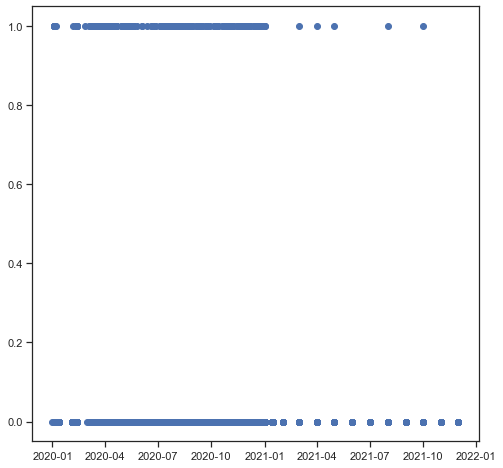

In [14]:
# Plot interaction between cdc_case_earliest_dt and DeathClass
# Create figure and plot space
fig, ax = plt.subplots(figsize=(8, 8))

# Add x-axis and y-axis
x = X_train['cdc_case_earliest_dt'].values
y = y_train
ax.scatter(x, y)

plt.show()

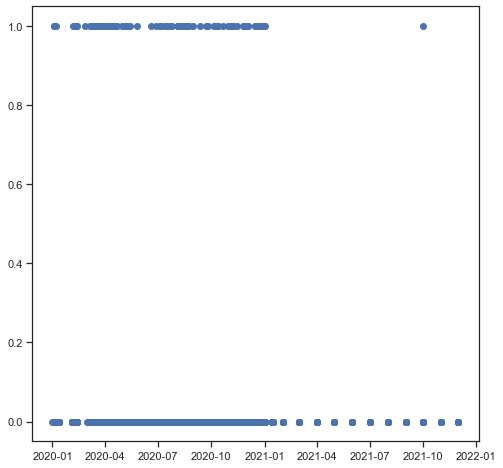

In [15]:
# Plot interaction between onset_dt and DeathClass
# Create figure and plot space
fig, ax = plt.subplots(figsize=(8, 8))

# Add x-axis and y-axis
x = X_train['onset_dt'].values
y = y_train
ax.scatter(x, y)

plt.show()

From these plots we can observe that there is no correlation between either of the continuous features and the target feature in this dataset.

<a id="2.2.3"></a>
### 2.2.3. Promising Continuous Features

I have decided not to choose either of the continuous features and they do not appear to be promising. There appears to be no correlation between either of the continous features and the target feature.

In [91]:
# Drop the continuous features 
X_train = X_train.drop(columns=['cdc_case_earliest_dt', 'onset_dt'])
X_test = X_test.drop(columns=['cdc_case_earliest_dt', 'onset_dt'])

<a id="2.2.4"></a>
### 2.2.4. Categorical Feature Pairwise Interactions with Target Feature

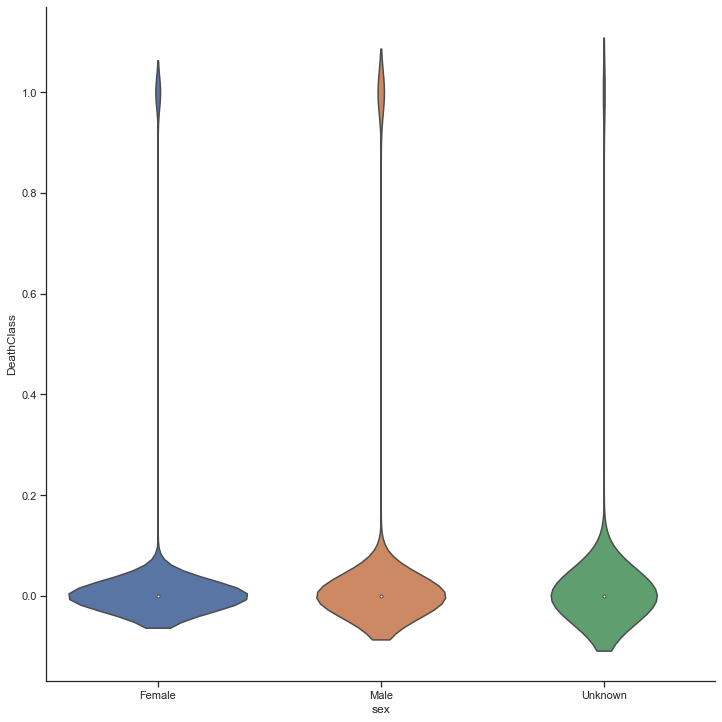

In [17]:
# Plot sex against DeathClass
plot = sns.catplot(x='sex', y='DeathClass', data=pd.concat([X_train, y_train], axis=1), kind="violin", height=10)
plot.savefig('plots/sex-DeathClass.png')

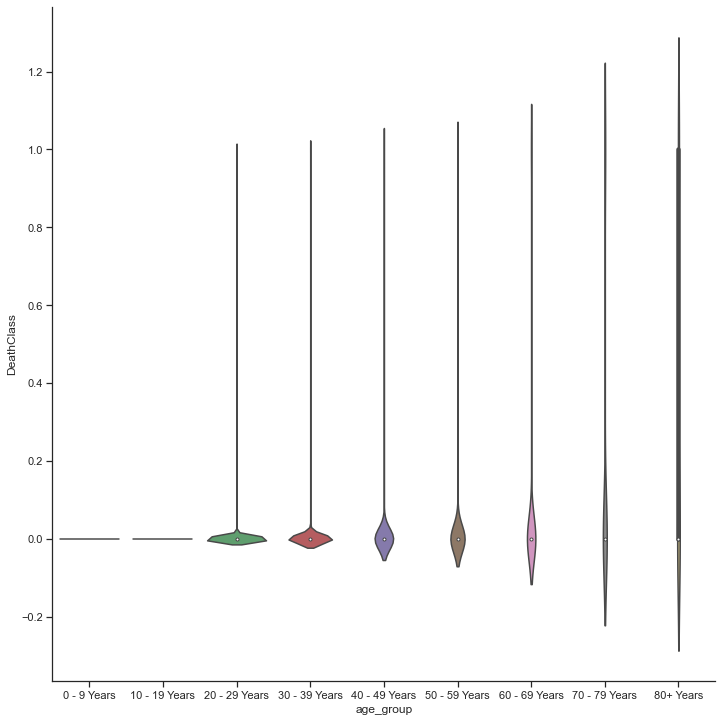

In [18]:
# Plot age_group against DeathClass
plot = sns.catplot(x='age_group', y='DeathClass', data=pd.concat([X_train, y_train], axis=1), kind="violin", height=10)
plot.savefig('plots/age_group-DeathClass.png')

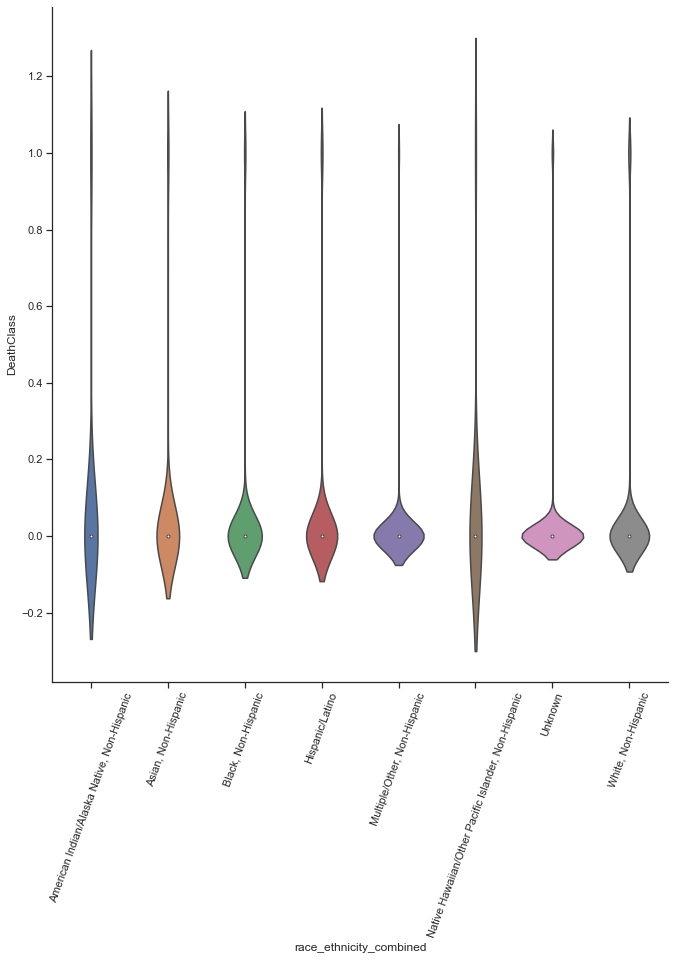

In [19]:
# Plot race_ethnicity_combined against DeathClass
plot = sns.catplot(x='race_ethnicity_combined', y='DeathClass', data=pd.concat([X_train, y_train], axis=1), kind="violin", height=10)
plot.set_xticklabels(rotation=70)
plot.savefig('plots/race_ethnicity_combined-DeathClass.png')

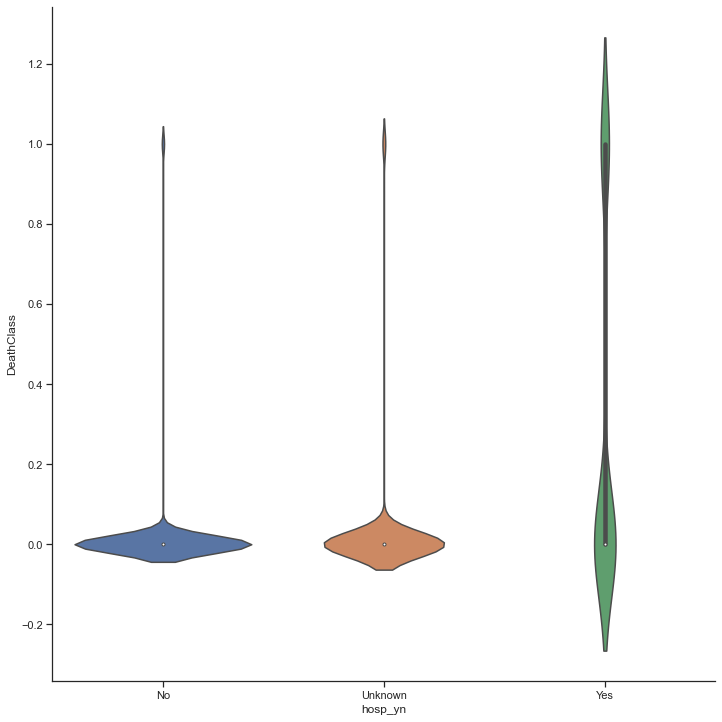

In [20]:
# Plot hosp_yn against DeathClass
plot = sns.catplot(x='hosp_yn', y='DeathClass', data=pd.concat([X_train, y_train], axis=1), kind="violin", height=10)
plot.savefig('plots/hosp_yn-DeathClass.png')

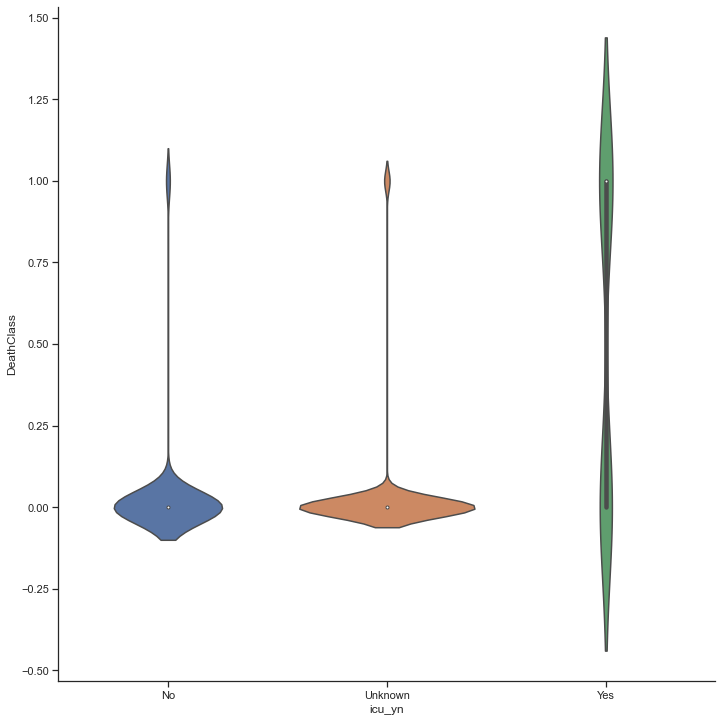

In [21]:
# Plot icu_yn against DeathClass
plot = sns.catplot(x='icu_yn', y='DeathClass', data=pd.concat([X_train, y_train], axis=1), kind='violin', height=10)
plot.savefig('plots/icu_yn-DeathClass.png')

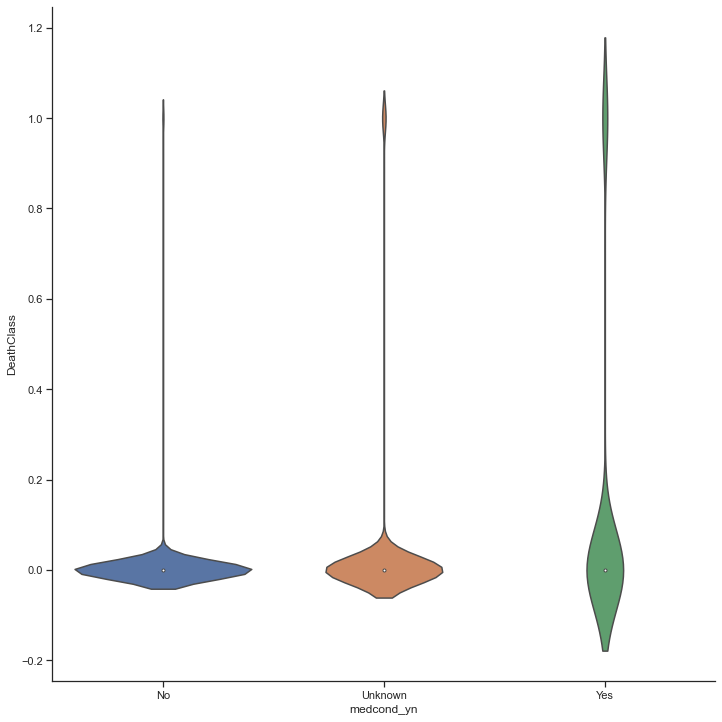

In [22]:
# Plot medcond_yn against DeathClass
plot = sns.catplot(x='medcond_yn', y='DeathClass', data=pd.concat([X_train, y_train], axis=1), kind="violin", height=10)
plot.savefig('plots/medcond_yn-DeathClass.png')

#### Observations

**sex**  
There appears to be no strong correlation between either sex and the target feature. However, in this dataset, a higher proportion of males have a death class of 1. This feature also has a very high number of unknown values.

**age_group**  
There seems to be some correlation with age_group and DeathClass. In the younger age groups there is little to no occurrences of the DeathClass equalling 1. As age progresses the data becomes evenly spread between across the target feature.

**race_ethnicity_combined**  
There does not appear to be any strong correlation between any category in this feature and the target feature.

**hosp_yn**  
It seems that a very high majority of the entries with 'No' for this feature resulted in a DeathClass of 0. There also appears to be some relationship between entries that answered 'Yes' and a DeathClass of 1.

**icu_yn**  
As with hosp_yn, for this feature there appears to be a slight relationship between the 'Yes' category of this feature and the target feature.

**medcond_yn**  
Again, while not as significant as the previous two features, there seems to be a slight relationship between the 'Yes' category and the target feature.


***

<a id="2.2.5"></a>
### 2.2.5. Promising Categorical Features

Based on the findings above I have decided that the features that I find promising are:
 - sex
 - age_group
 - hosp_yn
 - icu_yn
 - medcond_yn
    
In order to train the models I will convert these features into dummy variables.

#### Tranforming the Features To Dummy Variables

In [ ]:
# Create dummy variables for sex
df_dummies_sex = pd.get_dummies(X_train['sex'])
df_dummies_sex.head()
# Add dummies to the training set
X_train = pd.concat([X_train, df_dummies_sex[['Female', 'Male']]], axis=1)
#X_train.head()

In [93]:
# Create dummy variables for age_group
df_dummies_age = pd.get_dummies(X_train['age_group'])

# Add dummies to the training set
X_train = pd.concat([X_train, df_dummies_age], axis=1)
X_train = X_train.drop(columns='80+ Years')
#X_train.head()

In [94]:
# Create dummy variables for hosp_yn
df_dummies_hosp = pd.get_dummies(X_train['hosp_yn'])
df_dummies_hosp = df_dummies_hosp.rename(columns={'No':'hosp_No', 'Yes':'hosp_Yes'})
df_dummies_hosp = df_dummies_hosp.drop(columns='Unknown')

# Add dummies to the training set
X_train = pd.concat([X_train, df_dummies_hosp], axis=1)
#X_train.head()

In [95]:
# Create dummy variables for hosp_yn
df_dummies_icu = pd.get_dummies(X_train['icu_yn'])
df_dummies_icu = df_dummies_icu.rename(columns={'No':'icu_No', 'Yes':'icu_Yes'})
df_dummies_icu = df_dummies_icu.drop(columns='Unknown')

# Add dummies to the training set
X_train = pd.concat([X_train, df_dummies_icu], axis=1)
#X_train.head()

In [96]:
# Create dummy variables for hosp_yn
df_dummies_hosp = pd.get_dummies(X_train['medcond_yn'])
df_dummies_hosp = df_dummies_hosp.rename(columns={'No':'medcond_No', 'Yes':'medcond_Yes'})
df_dummies_hosp = df_dummies_hosp.drop(columns='Unknown')

# Add dummies to the training set
X_train = pd.concat([X_train, df_dummies_hosp], axis=1)
#X_train.head()

In [97]:
# Drop original features
X_train = X_train.drop(columns=['sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'medcond_yn'])
X_train.head()

,Female,Male,0 - 9 Years,10 - 19 Years,20 - 29 Years,30 - 39 Years,40 - 49 Years,50 - 59 Years,60 - 69 Years,70 - 79 Years,hosp_No,hosp_Yes,icu_No,icu_Yes,medcond_No,medcond_Yes
8284,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4965,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
940,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3178,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
5272,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [98]:
# Run the same code on the X_test dataset
# Create dummy variables for sex
df_dummies_sex = pd.get_dummies(X_test['sex'])
df_dummies_sex.head()
# Add dummies to the training set
X_test = pd.concat([X_test, df_dummies_sex[['Female', 'Male']]], axis=1)

# Create dummy variables for age_group
df_dummies_age = pd.get_dummies(X_test['age_group'])
# Add dummies to the training set
X_test = pd.concat([X_test, df_dummies_age], axis=1)
X_test = X_test.drop(columns='80+ Years')

# Create dummy variables for hosp_yn
df_dummies_hosp = pd.get_dummies(X_test['hosp_yn'])
df_dummies_hosp = df_dummies_hosp.rename(columns={'No':'hosp_No', 'Yes':'hosp_Yes'})
df_dummies_hosp = df_dummies_hosp.drop(columns='Unknown')
# Add dummies to the training set
X_test = pd.concat([X_test, df_dummies_hosp], axis=1)

# Create dummy variables for hosp_yn
df_dummies_icu = pd.get_dummies(X_test['icu_yn'])
df_dummies_icu = df_dummies_icu.rename(columns={'No':'icu_No', 'Yes':'icu_Yes'})
df_dummies_icu = df_dummies_icu.drop(columns='Unknown')
# Add dummies to the training set
X_test = pd.concat([X_test, df_dummies_icu], axis=1)

# Create dummy variables for hosp_yn
df_dummies_hosp = pd.get_dummies(X_test['medcond_yn'])
df_dummies_hosp = df_dummies_hosp.rename(columns={'No':'medcond_No', 'Yes':'medcond_Yes'})
df_dummies_hosp = df_dummies_hosp.drop(columns='Unknown')
# Add dummies to the training set
X_test = pd.concat([X_test, df_dummies_hosp], axis=1)

# Drop original features
X_test = X_test.drop(columns=['sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'medcond_yn'])
X_test.head()

,Female,Male,0 - 9 Years,10 - 19 Years,20 - 29 Years,30 - 39 Years,40 - 49 Years,50 - 59 Years,60 - 69 Years,70 - 79 Years,hosp_No,hosp_Yes,icu_No,icu_Yes,medcond_No,medcond_Yes
5179,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1
5467,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3501,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
6039,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
7999,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


***

<a id="3"></a>
# 3. Predictive Modeling: Linear Regression

<a id="3.1"></a>
## 3.1. Linear Regression Model

In [30]:
# Train a linear regression on the training set
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

<a id="3.2"></a>
## 3.2. Coefficients of the Model

In [31]:
# Print the coefficients learned by the model and discuss their role in the model.
print("Features: \n", X_train.columns)
print("\nCoeficients: \n", linear_reg.coef_)
print("\nIntercept: \n", linear_reg.intercept_)

Features: 
 Index(['Female', 'Male', '0 - 9 Years', '10 - 19 Years', '20 - 29 Years',
       '30 - 39 Years', '40 - 49 Years', '50 - 59 Years', '60 - 69 Years',
       '70 - 79 Years', 'hosp_No', 'hosp_Yes', 'icu_No', 'icu_Yes',
       'medcond_No', 'medcond_Yes'],
      dtype='object')

Coeficients: 
 [[-0.00501261  0.01105382 -0.23826563 -0.23470969 -0.23739497 -0.23630433
  -0.23391915 -0.23563273 -0.21934403 -0.14217435 -0.0047853   0.16033332
  -0.03231908  0.27884578  0.00726759  0.03645279]]

Intercept: 
 [0.23556737]


#### Interpretation of Coefficients

**Sex Coefficients**
 - **Female:** if female, the probabilty of death occurring decreases by 0.005 as compared to the sex being unknown, all other variables remaining constant.  
 
 - **Male:** if male, the probability of death occurring increases by 0.011 as compared to sex being unkown, all other variables remaining constant.
 
**Age Coefficients**
 - **0 - 9 Years:** if the age is in this range, the probability of death occurring decreases by 0.238 as compared to age being >= 80, all other variables remaining constant.
 
 - **10 - 19 Years:** if the age is in this range, the probability of death occurring decreases by 0.235 as compared to age being >= 80, all other variables remaining constant
 
 - **20 - 29 Years:** if the age is in this range, the probability of death occurring decreases by 0.237 as compared to age being >= 80, all other variables remaining constant
 
 - **30 - 39 Years:** if the age is in this range, the probability of death occurring decreases by 0.236 as compared to age being >= 80, all other variables remaining constant
 
 - **40 - 49 Years:** if the age is in this range, the probability of death occurring decreases by 0.234 as compared to age being >= 80, all other variables remaining constant
 
 - **50 - 59 Years:** if the age is in this range, the probability of death occurring decreases by 0.236 as compared to age being >= 80, all other variables remaining constant
 
 - **60 - 69 Years:** if the age is in this range, the probability of death occurring decreases by 0.219 as compared to age being >= 80, all other variables remaining constant
 
 - **70 - 79 Years:** if the age is in this range, the probability of death occurring decreases by 0.142 as compared to age being >= 80, all other variables remaining constant
 
**Hospitalisation Status Coefficients**  
 - **hosp_no:** if the patient was not hospitalise, the probability of death occurring decreases by 0.004 as compared to hospitalisation status being unknown, all other variables remaining constant.
 
 - **hosp_yes:** if the patient was hospitalised, the probability of death occurring increases by 0.16 as compared to hospitalisation status being unknown, all other variables remaining constant.
 
**ICU Status Coefficients**
 - **icu_no:** if the patient was not admitted to ICU, the probability of death occurring decreases by 0.032 as compared to ICU status being unknown, all other variables remaining constant.
 
 - **icu_yes:** if the patient was admitted to ICU, the probability of death occurring increases by 0.279 as compared to ICU status being unknown, all other variables remaining constant.
 
**Underlying Medical Condition Coefficient**
 - **medcond_no:** if the patient has no pre-existing medical conditions, the probability of death occurring increases by 0.007 as compared to the presence of underlying medical conditions being unknown, all other variables remaining constant.
 
 - **medcond_yes:** if the patient has pre-existing medical conditions, the probability of death occurring increases by 0.036 as compared to the presence of underlying medical conditions being unknown, all other variables remaining constant.

<a id="3.3"></a>
## 3.3. Predicted Target Feature Value

In [32]:
# Print the predicted target feature value for the first 10 training examples
linear_reg_predictions = linear_reg.predict(X_train)
print("\nPredictions with linear regression: \n")
actual_vs_predicted_linear_reg = pd.concat([y_train, pd.DataFrame(linear_reg_predictions, columns=['Predicted'], index=y.index)], axis=1)
actual_vs_predicted_linear_reg.head(10)


Predictions with linear regression: 



,DeathClass,Predicted
8284,0.0,0.225769
4965,0.0,0.225769
940,0.0,0.042656
3178,0.0,-0.009863
5272,0.0,0.248714
7622,0.0,-0.010535
3370,0.0,0.010317
416,0.0,-0.008150
6742,0.0,-0.037548
7774,0.0,0.187610


In [33]:
# Threshold the predicted target feature value given by the linear 
#     regression model at 0.5, to get the predicted class for each example.
for index, row in actual_vs_predicted_linear_reg.iterrows():
    if row['Predicted'] > 0.5:
        row['Predicted'] = 1.0
    else:
        row['Predicted'] = 0.0
        
linear_reg_threshold_predictions = pd.DataFrame(actual_vs_predicted_linear_reg['Predicted'])

In [35]:
# Print the predicted class for the first 10 examples. 
print("\nThresholded predictions with linear regression: \n")
actual_vs_predicted_linear_reg.head(10)


Thresholded predictions with linear regression: 



,DeathClass,Predicted
8284,0.0,0.0
4965,0.0,0.0
940,0.0,0.0
3178,0.0,0.0
5272,0.0,0.0
7622,0.0,0.0
3370,0.0,0.0
416,0.0,0.0
6742,0.0,0.0
7774,0.0,0.0


#### Classification Measures

In [36]:
# Print Accuracy
print('Accuracy: ', metrics.accuracy_score(y_train, linear_reg_threshold_predictions) )

# Print Confusion Matrix
print('\nConfusion Matrix: \n', metrics.confusion_matrix(y_train, linear_reg_threshold_predictions) )

# Print Classification Report
print('\nClassification Report: \n', metrics.classification_report(y_train, linear_reg_threshold_predictions))

Accuracy:  0.9652451309603761

Confusion Matrix: 
 [[5729   15]
 [ 192   20]]

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      5744
         1.0       0.57      0.09      0.16       212

    accuracy                           0.97      5956
   macro avg       0.77      0.55      0.57      5956
weighted avg       0.95      0.97      0.95      5956



The Linear Regression model has a very high accuracy but this is possibly due to the very high imbalance in the target feature of the dataset.  
Looking at the confusion matrix we can see that there is a high number of False Negatives with this model. Given the problem domain I would be hoping for this measure to be as low as possible.  

<a id="3.4"></a>
## 3.4. Model Evaluation

In [156]:
# Evaluate the model using classification evaluation measures on the hold-out (30%) test set.
linear_reg_predictions_test = (linear_reg.predict(X_test) >= 0.5) * 1.0

# Print predictions
actual_vs_predicted_linear_reg_test = pd.DataFrame(y_test)
actual_vs_predicted_linear_reg_test['Predicted'] = linear_reg_predictions_test
#print("\nPredictions with linear regression on test set: \n")
actual_vs_predicted_linear_reg_test

,DeathClass,Predicted
5179,0.0,0.0
5467,0.0,0.0
3501,0.0,0.0
6039,0.0,0.0
7999,0.0,0.0
...,...,...
4228,0.0,0.0
7209,0.0,0.0
6995,1.0,0.0
1355,0.0,0.0


In [157]:
# Print Accuracy
print('Accuracy: ', metrics.accuracy_score(actual_vs_predicted_linear_reg_test['DeathClass'], actual_vs_predicted_linear_reg_test['Predicted']) )

# Print Confusion Matrix
print('\nConfusion Matrix: \n', metrics.confusion_matrix(actual_vs_predicted_linear_reg_test['DeathClass'], actual_vs_predicted_linear_reg_test['Predicted']) )

# Print Classification Report
print('\nClassification Report: \n', metrics.classification_report(actual_vs_predicted_linear_reg_test['DeathClass'], actual_vs_predicted_linear_reg_test['Predicted']) )

Accuracy:  0.9663141402271838

Confusion Matrix: 
 [[2465    5]
 [  81    2]]

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2470
         1.0       0.29      0.02      0.04        83

    accuracy                           0.97      2553
   macro avg       0.63      0.51      0.51      2553
weighted avg       0.95      0.97      0.95      2553



Running the regression on the test dataset we get a similar resulting accuracy. 
The confusion matrix appears to be better however the test dataset was much smaller than the training dataset. This time around the model actually appears to be less precise and less accurate at predicting the target feature.

#### Cross-Validated Model

In [169]:
# Combine Test and Train dataset
X = X_train
X = X.append(X_test)

y = y_train
y = y.append(y_test)

In [186]:
# Run cross-validation model
scores = cross_val_score(LinearRegression(), X, y['DeathClass'], cv=10)
print(scores)
print(scores.mean())

[0.27367873 0.20873618 0.22771442 0.23018985 0.25574683 0.2593348
 0.22795226 0.16647371 0.20794109 0.22292421]
0.22806920912498221


The accuracy score from the cross-validated Linear Regression is significantly lower than the model train on the 70/30 split suggesting that a linear regression model does not accurately predict the relationship between the descriptive features and the target feature.

***

<a id="4"></a>
# 4. Predictive Modeling: Logistic Regression

<a id="4.1"></a>
## 4.1. Logistic Regression Model

In [ ]:
# Train a logistic regression on the training set
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

<a id="4.2"></a>
## 4.2. Coefficients of the Model

In [100]:
# Print the coefficients learned by the model and discuss their role in the model.
print("Features: \n", X_train.columns)
print("\nCoeficients: \n", logistic_reg.coef_)
print("\nIntercept: \n", logistic_reg.intercept_)

Features: 
 Index(['Female', 'Male', '0 - 9 Years', '10 - 19 Years', '20 - 29 Years',
       '30 - 39 Years', '40 - 49 Years', '50 - 59 Years', '60 - 69 Years',
       '70 - 79 Years', 'hosp_No', 'hosp_Yes', 'icu_No', 'icu_Yes',
       'medcond_No', 'medcond_Yes'],
      dtype='object')

Coeficients: 
 [[-0.07566483  0.5180152  -2.61498524 -3.09512671 -3.51260243 -3.21077715
  -2.49374316 -2.28741868 -1.63821742 -0.67015597 -0.49958645  1.73413913
  -0.83331514  0.97007651 -0.7567625   0.78217131]]

Intercept: 
 [-2.03431694]


#### Interpretations of Coefficients

**Sex Coefficients**
 - **Female:** if the patient is female, the probabilty of death occurring decreases by 0.077 as compared to the sex being unknown, all other variables remaining constant.  
 
 - **Male:** if the patiet is male, the probability of death occurring increases by 0.518 as compared to sex being unkown, all other variables remaining constant.
 
**Age Coefficients**
 - **0 - 9 Years:** if the age is in this range, the probability of death occurring decreases by 2.615 as compared to age being >= 80, all other variables remaining constant.
 
 - **10 - 19 Years:** if the age is in this range, the probability of death occurring decreases by 3.095 as compared to age being >= 80, all other variables remaining constant
 
 - **20 - 29 Years:** if the age is in this range, the probability of death occurring decreases by 3.513 as compared to age being >= 80, all other variables remaining constant
 
 - **30 - 39 Years:** if the age is in this range, the probability of death occurring decreases by 3.21 as compared to age being >= 80, all other variables remaining constant
 
 - **40 - 49 Years:** if the age is in this range, the probability of death occurring decreases by 2.494 as compared to age being >= 80, all other variables remaining constant
 
 - **50 - 59 Years:** if the age is in this range, the probability of death occurring decreases by 2.287 as compared to age being >= 80, all other variables remaining constant
 
 - **60 - 69 Years:** if the age is in this range, the probability of death occurring decreases by 1.638 as compared to age being >= 80, all other variables remaining constant
 
 - **70 - 79 Years:** if the age is in this range, the probability of death occurring decreases by 0.67 as compared to age being >= 80, all other variables remaining constant
 
**Hospitalisation Status Coefficients**  
 - **hosp_no:** if the patient was not hospitalise, the probability of death occurring decreases by 0.5 as compared to hospitalisation status being unknown, all other variables remaining constant.
 
 - **hosp_yes:** if the patient was hospitalised, the probability of death occurring increases by 1.734 as compared to hospitalisation status being unknown, all other variables remaining constant.
 
**ICU Status Coefficients**
 - **icu_no:** if the patient was not admitted to ICU, the probability of death occurring decreases by 0.833 as compared to ICU status being unknown, all other variables remaining constant.
 
 - **icu_yes:** if the patient was admitted to ICU, the probability of death occurring increases by 0.97 as compared to ICU status being unknown, all other variables remaining constant.
 
**Underlying Medical Condition Coefficient**
 - **medcond_no:** if the patient has no pre-existing medical conditions, the probability of death occurring increases by 0.757 as compared to the presence of underlying medical conditions being unknown, all other variables remaining constant.
 
 - **medcond_yes:** if the patient has pre-existing medical conditions, the probability of death occurring increases by 0.782 as compared to the presence of underlying medical conditions being unknown, all other variables remaining constant.

<a id="4.3"></a>
## 4.3. Predicted Target Feature Value

In [102]:
# Print the predicted target feature value for the first 10 training examples
logistic_reg_predictions = logistic_reg.predict(X_train)

In [103]:
print("\nPredictions with logistic regression: \n")
actual_vs_predicted_logistic_reg = pd.concat([y_train, pd.DataFrame(logistic_reg_predictions, columns=['Predicted'], index=y.index)], axis=1)
actual_vs_predicted_logistic_reg.head(10)


Predictions with logistic regression: 



ValueError: Shape of passed values is (5956, 1), indices imply (8509, 1)

#### Classification Measures

In [104]:
# Print Accuracy
print('Accuracy: ', metrics.accuracy_score(y_train, logistic_reg_predictions) )

# Print Confusion Matrix
print('\nConfusion Matrix: \n', metrics.confusion_matrix(y_train, logistic_reg_predictions) )

# Print Classification Report
print('\nClassification Report: \n', metrics.classification_report(y_train, logistic_reg_predictions))

Accuracy:  0.9664204163868368

Confusion Matrix: 
 [[5711   33]
 [ 167   45]]

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      5744
         1.0       0.58      0.21      0.31       212

    accuracy                           0.97      5956
   macro avg       0.77      0.60      0.65      5956
weighted avg       0.96      0.97      0.96      5956



The Logistical Regression model has a similar level of accuracy as the Linear Regression model. However, the recall measure for the target feature is higher meaning it is better at correctly predicting the target feature.

<a id="4.4"></a>
## 4.4. Model Evaluation

In [158]:
# Evaluate the model using classification evaluation measures on the hold-out (30%) test set.
logistic_reg_predictions_test = (logistic_reg.predict(X_test) >= 0.5) * 1.0

# Print predictions
actual_vs_predicted_logistic_reg_test = pd.DataFrame(y_test)
actual_vs_predicted_logistic_reg_test['Predicted'] = logistic_reg_predictions_test
#print("\nPredictions with logistic regression on test set: \n")
actual_vs_predicted_logistic_reg_test

,DeathClass,Predicted
5179,0.0,0.0
5467,0.0,0.0
3501,0.0,0.0
6039,0.0,0.0
7999,0.0,0.0
...,...,...
4228,0.0,0.0
7209,0.0,0.0
6995,1.0,0.0
1355,0.0,0.0


In [159]:
# Print Accuracy
print('Accuracy: ', metrics.accuracy_score(actual_vs_predicted_logistic_reg_test['DeathClass'], actual_vs_predicted_logistic_reg_test['Predicted']) )

# Print Confusion Matrix
print('\nConfusion Matrix: \n', metrics.confusion_matrix(actual_vs_predicted_logistic_reg_test['DeathClass'], actual_vs_predicted_logistic_reg_test['Predicted']) )

# Print Classification Report
print('\nClassification Report: \n', metrics.classification_report(actual_vs_predicted_logistic_reg_test['DeathClass'], actual_vs_predicted_logistic_reg_test['Predicted']) )

Accuracy:  0.9682726204465335

Confusion Matrix: 
 [[2460   10]
 [  71   12]]

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2470
         1.0       0.55      0.14      0.23        83

    accuracy                           0.97      2553
   macro avg       0.76      0.57      0.61      2553
weighted avg       0.96      0.97      0.96      2553



After running the model on the test dataset we see that the accuracy is still very high. There has been a drop in the recall measure for the target feature however this is still higher than that for the linear regression.

#### Cross-validated Model

In [185]:
# Run cross-validation model
scores = cross_val_score(LogisticRegression(), X, y['DeathClass'], cv=10)
print(scores)
print(scores.mean())

[0.96709753 0.96709753 0.96709753 0.96827262 0.96827262 0.9706228
 0.96357227 0.96357227 0.96709753 0.96823529]
0.9670937996820349


For the logistical regression the cross-validated model return an accuracy score similar to the model trained on the 70/30 split. It is also significantly higher than the score for the cross-validated linear regression model.

***

<a id="5"></a>
# 5. Predictive Modeling: Random Forest

<a id="5.1"></a>
## 5.1. Random Forest Model

In [105]:
# Train a random forest on the training dataset
random_forest = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
random_forest.fit(X_train, y_train)

<ipython-input-105-df86d8b69cf2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


RandomForestClassifier(oob_score=True, random_state=1)

<a id="5.2"></a>
## 5.2. Model Interpretation

In [106]:
# Print the feature importance learned by the model and discuss their role in the model.
pd.DataFrame({'Feature': X_train.columns, 'Importance': random_forest.feature_importances_})

,Feature,Importance
0,Female,0.031687
1,Male,0.029406
2,0 - 9 Years,0.027393
3,10 - 19 Years,0.020336
4,20 - 29 Years,0.036455
5,30 - 39 Years,0.033528
6,40 - 49 Years,0.055240
7,50 - 59 Years,0.066957
8,60 - 69 Years,0.068685
9,70 - 79 Years,0.067722


From the feature importance table above we can see that no feature has an importance level above 0.5. The most important feature as determined by this model is hosp_Yes. The next important feature is icu_Yes. In relation to these two features, the other features have very low importance levels.

With the random forest model it is possible to determine the level of importance each feature has for the model but not how these features alter the target feature in relation to changes in the input features.

<a id="5.3"></a>
## 5.3. Predicted Target Value

In [160]:
# Print the predicted target feature value for the first 10 training examples
random_forest_predictions = random_forest.predict(X_train)
print("\nPredictions with logistic regression: \n")
actual_vs_predicted_random_forest = pd.concat([y_train, pd.DataFrame(random_forest_predictions, columns=['Predicted'], index=y.index)], axis=1)
actual_vs_predicted_random_forest.head(10)


Predictions with logistic regression: 



ValueError: Shape of passed values is (5956, 1), indices imply (8509, 1)

#### Classification Measures

In [153]:
# Print Accuracy
print('Accuracy: ', metrics.accuracy_score(y_train, random_forest_predictions) )

# Print OOB Score
print('\nOut-of-Bag Accuracy: ', random_forest.oob_score_)

# Print Confusion Matrix
print('\nConfusion Matrix: \n', metrics.confusion_matrix(y_train, random_forest_predictions) )

# Print Classification Report
print('\nClassification Report: \n', metrics.classification_report(y_train, random_forest_predictions))

Accuracy:  0.9699462726662189

Out-of-Bag Accuracy:  0.9630624580255205

Confusion Matrix: 
 [[5721   23]
 [ 156   56]]

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      5744
         1.0       0.71      0.26      0.38       212

    accuracy                           0.97      5956
   macro avg       0.84      0.63      0.68      5956
weighted avg       0.96      0.97      0.96      5956



The accuracy of the model on the training dataset and the Out-of-Bag accuracy are very high. However, again this could be due to the fact that the dataset is heavily imbalanced. The recall value for the target feature is slightly higher than that of the logistic regression.

<a id="5.4"></a>
## 5.4. Model Evaluation

In [161]:
# Evaluate the model using classification evaluation measures on the hold-out (30%) test set.
random_forest_predictions_test = (random_forest.predict(X_test) >= 0.5) * 1.0

# Print predictions
actual_vs_predicted_random_forest_test = pd.DataFrame(y_test)
actual_vs_predicted_random_forest_test['Predicted'] = random_forest_predictions_test
#print("\nPredictions with random forest on test set: \n")
actual_vs_predicted_random_forest_test

,DeathClass,Predicted
5179,0.0,0.0
5467,0.0,0.0
3501,0.0,0.0
6039,0.0,0.0
7999,0.0,0.0
...,...,...
4228,0.0,0.0
7209,0.0,0.0
6995,1.0,0.0
1355,0.0,0.0


In [162]:
# Print Accuracy
print('Accuracy: ', metrics.accuracy_score(actual_vs_predicted_random_forest_test['DeathClass'], actual_vs_predicted_random_forest_test['Predicted']) )

# Print Confusion Matrix
print('\nConfusion Matrix: \n', metrics.confusion_matrix(actual_vs_predicted_random_forest_test['DeathClass'], actual_vs_predicted_random_forest_test['Predicted']) )

# Print Classification Report
print('\nClassification Report: \n', metrics.classification_report(actual_vs_predicted_random_forest_test['DeathClass'], actual_vs_predicted_random_forest_test['Predicted']) )

Accuracy:  0.9690560125342734

Confusion Matrix: 
 [[2462    8]
 [  71   12]]

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2470
         1.0       0.60      0.14      0.23        83

    accuracy                           0.97      2553
   macro avg       0.79      0.57      0.61      2553
weighted avg       0.96      0.97      0.96      2553



The accuracy has remained almost the same. The recall value has dropped slightly and is the same as the logistic regression.

#### Cross-validated model

In [183]:
scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X, y['DeathClass'], cv=10)
print(scores)
print(scores.mean())

[0.960047   0.96239718 0.96709753 0.9706228  0.96709753 0.960047
 0.96944771 0.96944771 0.96592244 0.96705882]
0.9659185733047625


The cross-validated model resulted in a similar accuracy. This could be due to the multpiple splits accounting for the high imbalance in the target feature.

***

<a id="6"></a>
# 6. Improving the Predictive Models

<a id="6.1"></a>
## 6.1. Best Predictive Model

The model I have chosen which I beleive is best at predicted the target feature is the Random Forest model.

This model had the highest accuracy of the three models, however, I am cautious that this is a very unbalanced dataset. One key aspect of this model is that it predicted the lowest number of False Negatives. Given the problem domain is in the health sector and in particular these models are predicting the occurence of death, I strongly believe that we should aim to minimise this evaluation measure.

While this model does predict a slightly higher number of False Positives compared to the Linear Regression, it also predicts a higher number of True Positives which is the target feature and the aim of this project.

<a id="6.2"></a>
## 6.2. Problem Summary

It was hard to definitively capture the relationship between the descriptive features and the target feature. Each model initially returned a very high accuracy measure, however, I would be extremely skeptical of these results and there was a very high imbalance in the target feature in this dataset. Cross-validation proved the linear regression to be very inaccurate, while the accuracy of the other two model remained relatively the same. 
The models may be improved by training on a more robust dataset. The dataset used in this project had a very high number of unknown values for many of the features.
Adding a new feature, such as the time from infection to the first sign of symptoms, may also help to improve the models.

<a id="6.3"></a>
## 6.3. Model Evaluation on New Test Dataset

In [130]:
# Load in cleaned dataset from Homework 1
df_unseen = pd.read_csv('data/24032021-covid19-cdc-deathyn-recent-10k.csv')

In [131]:
df_unseen.head(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2021/01/22,2021/01/22,NaN,NaN,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,Missing,No,Missing
1,2021/01/26,NaN,NaN,NaN,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Missing,No,Missing
2,2021/02/03,2021/02/05,NaN,2021/02/03,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",Missing,Missing,No,Missing
3,2021/02/05,2021/02/05,2021/02/07,2021/02/05,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,No,No
4,2021/01/27,2021/01/27,NaN,NaN,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Missing,No,Missing
5,2021/02/07,2021/02/07,2021/02/07,NaN,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,Unknown
6,2021/01/26,NaN,NaN,NaN,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Unknown,Missing,No,Missing
7,2021/02/04,NaN,NaN,NaN,Laboratory-confirmed case,Male,70 - 79 Years,"White, Non-Hispanic",Missing,Missing,No,Missing
8,2021/01/23,NaN,NaN,NaN,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,Unknown,Missing,No,Missing
9,2021/01/25,2021/01/27,NaN,2021/01/25,Probable Case,Female,70 - 79 Years,"White, Non-Hispanic",No,Missing,No,Missing


In [132]:
# Transform dataset

In [133]:
# Drop redundant features
df_unseen = df_unseen.drop(columns=[
    'cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt',
    'current_status', 'race_ethnicity_combined'
])

In [134]:
# Create Dummy Variables
# Create dummy variables for sex
df_dummies_sex = pd.get_dummies(df_unseen['sex'])
df_dummies_sex.head()
# Add dummies to the training set
df_unseen = pd.concat([df_unseen, df_dummies_sex[['Female', 'Male']]], axis=1)

# Create dummy variables for age_group
df_dummies_age = pd.get_dummies(df_unseen['age_group'])
# Add dummies to the training set
df_unseen = pd.concat([df_unseen, df_dummies_age], axis=1)
df_unseen = df_unseen.drop(columns='80+ Years')

# Create dummy variables for hosp_yn
df_dummies_hosp = pd.get_dummies(df_unseen['hosp_yn'])
df_dummies_hosp = df_dummies_hosp.rename(columns={'No':'hosp_No', 'Yes':'hosp_Yes'})
df_dummies_hosp = df_dummies_hosp.drop(columns='Unknown')
# Add dummies to the training set
df_unseen = pd.concat([df_unseen, df_dummies_hosp], axis=1)

# Create dummy variables for hosp_yn
df_dummies_icu = pd.get_dummies(df_unseen['icu_yn'])
df_dummies_icu = df_dummies_icu.rename(columns={'No':'icu_No', 'Yes':'icu_Yes'})
df_dummies_icu = df_dummies_icu.drop(columns='Unknown')
# Add dummies to the training set
df_unseen = pd.concat([df_unseen, df_dummies_icu], axis=1)

# Create dummy variables for hosp_yn
df_dummies_hosp = pd.get_dummies(df_unseen['medcond_yn'])
df_dummies_hosp = df_dummies_hosp.rename(columns={'No':'medcond_No', 'Yes':'medcond_Yes'})
df_dummies_hosp = df_dummies_hosp.drop(columns='Unknown')
# Add dummies to the training set
df_unseen = pd.concat([df_unseen, df_dummies_hosp], axis=1)

# Drop original features
df_unseen = df_unseen.drop(columns=['sex', 'age_group', 'hosp_yn', 'icu_yn', 'medcond_yn', 'Missing'])
df_unseen.head()


,death_yn,Female,Male,0 - 9 Years,10 - 19 Years,20 - 29 Years,30 - 39 Years,40 - 49 Years,50 - 59 Years,60 - 69 Years,70 - 79 Years,hosp_No,hosp_Yes,icu_No,icu_Yes,medcond_No,medcond_Yes
0,No,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,No,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,No,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,No,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,No,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [135]:
X_unseen = df_unseen.drop(columns='death_yn')

In [138]:
# Transform target feature death_yn into a categorical feature named death class
y_unseen = pd.DataFrame(df_unseen['death_yn'])
DeathClass = (y_unseen.death_yn == "Yes") * 1.0

# Add DeathClass to dataframe and drop death_yn
y_unseen['DeathClass'] = DeathClass
y_unseen.drop('death_yn', axis=1, inplace=True)
#y_unseen

,DeathClass
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
9995,0.0
9996,0.0
9997,0.0
9998,0.0


In [145]:
# Evaluate model on the new test dataset
# Print the predicted target feature value for the first 10 training examples
unseen_predictions = random_forest.predict(X_unseen)
print("\nPredictions with logistic regression: \n")
#actual_vs_predicted_unseen = pd.concat([y_unseen, pd.DataFrame(unseen_predictions, columns=['Predicted'], index=y.index)], axis=1)
#actual_vs_predicted_unseen.head(10)
actual_vs_predicted_unseen = pd.DataFrame(y_unseen)
actual_vs_predicted_unseen['Predicted'] = unseen_predictions
actual_vs_predicted_unseen.head(10)


Predictions with logistic regression: 



,DeathClass,Predicted
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


In [151]:
# Print Accuracy
print('Accuracy: ', metrics.accuracy_score(actual_vs_predicted_unseen['DeathClass'], actual_vs_predicted_unseen['Predicted']) )

# Print Confusion Matrix
print('\nConfusion Matrix: \n', metrics.confusion_matrix(actual_vs_predicted_unseen['DeathClass'], actual_vs_predicted_unseen['Predicted']) )

# Print Classification Report
print('\nClassification Report: \n', metrics.classification_report(actual_vs_predicted_unseen['DeathClass'], actual_vs_predicted_unseen['Predicted']) )

Accuracy:  0.9866

Confusion Matrix: 
 [[9857   22]
 [ 112    9]]

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9879
         1.0       0.29      0.07      0.12       121

    accuracy                           0.99     10000
   macro avg       0.64      0.54      0.56     10000
weighted avg       0.98      0.99      0.98     10000



Through the evaluation on the unseen dataset this model shows to have a very high accuracy however I don't believe this statistic to be very accurate.  
The balance between the False Negatives and True Positives is highly skewed towards the False Negatives.

***

[Back to top](#top)